### 1) Import the necessary libraries

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import percentile
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import skew
from scipy.stats import ttest_1samp, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api         as     sm
from   statsmodels.formula.api import ols

### 2) Read the data as a data frame

In [55]:
inc_data = pd.read_csv("insurance.csv")

### 3a) Shape of the data

In [56]:
data_shape = inc_data.shape
data_shape

(1338, 7)

### 3b) Data type of each attribute

In [57]:
inc_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

### 3c) Checking the presence of missing values

In [58]:
df = pd.DataFrame(inc_data)
df.isnull()

,age,sex,bmi,children,smoker,region,charges
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1333,False,False,False,False,False,False,False
1334,False,False,False,False,False,False,False
1335,False,False,False,False,False,False,False
1336,False,False,False,False,False,False,False


### 3d) 5 point summary of numerical attributes

In [59]:
quartiles = df.describe(include=[np.number])
quartiles.drop(['count','std','mean'],axis = 0)

,age,bmi,children,charges
min,18.0,15.96000,0.0,1121.873900
25%,27.0,26.29625,0.0,4740.287150
50%,39.0,30.40000,1.0,9382.033000
75%,51.0,34.69375,2.0,16639.912515
max,64.0,53.13000,5.0,63770.428010


### 3e) Distribution of ‘bmi’, ‘age’ and ‘charges’ columns.

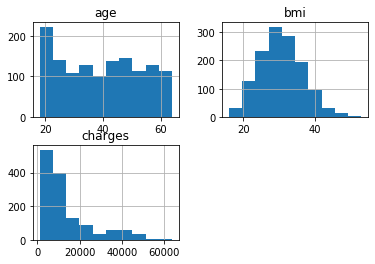

In [60]:
df1 = pd.DataFrame(inc_data, columns = ['bmi', 'age', 'charges'] ) 
df1.hist()
plt.show()

### 3f) Measure of skewness of ‘bmi’, ‘age’ and ‘charges’ columns

In [61]:
df.drop(['children'],axis = 1).skew(axis = 0, skipna = True)

age        0.055673
bmi        0.284047
charges    1.515880
dtype: float64

### 3g) Checking the presence of outliers in ‘bmi’, ‘age’ and ‘charges columns

##### 1. outliers in ‘bmi’

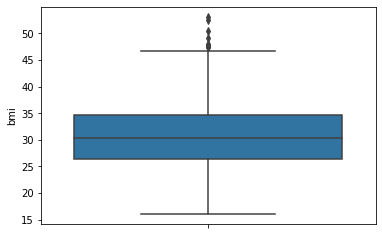

In [62]:
sns.boxplot(y=df['bmi'])

##### 2. outliers in ‘age’

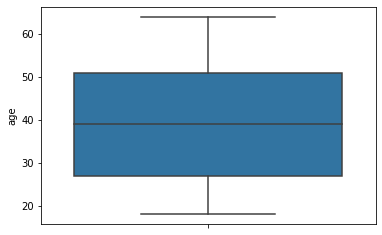

In [63]:
sns.boxplot(y=df['age'])

##### 3. outliers in ‘charges’

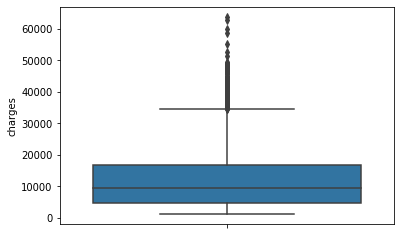

In [64]:
sns.boxplot(y=df['charges'])

### 3h) Distribution of categorical columns (include children)

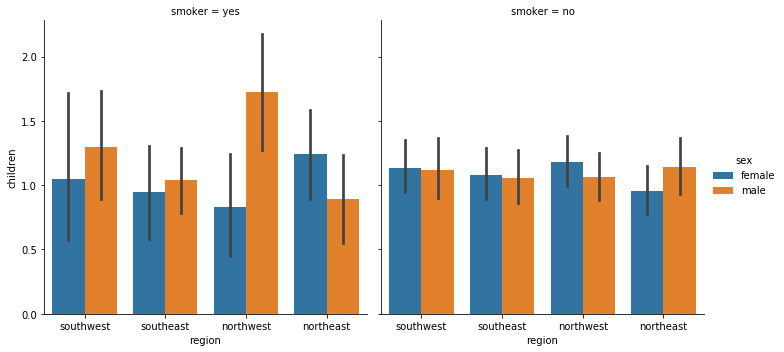

In [65]:
sns.catplot(x="region", y="children", hue="sex", col="smoker", kind="bar", data=df);

### 3i) Pair plot that includes all the columns of the data frame

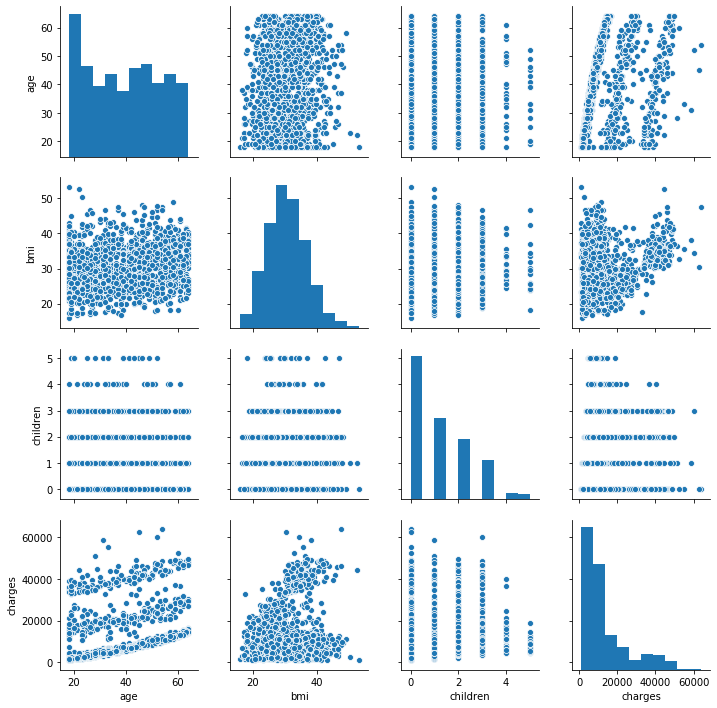

In [66]:
sns.pairplot(df)

##### 1) Pair Plot visualizing male population and separating smokers and non-smokers with hue

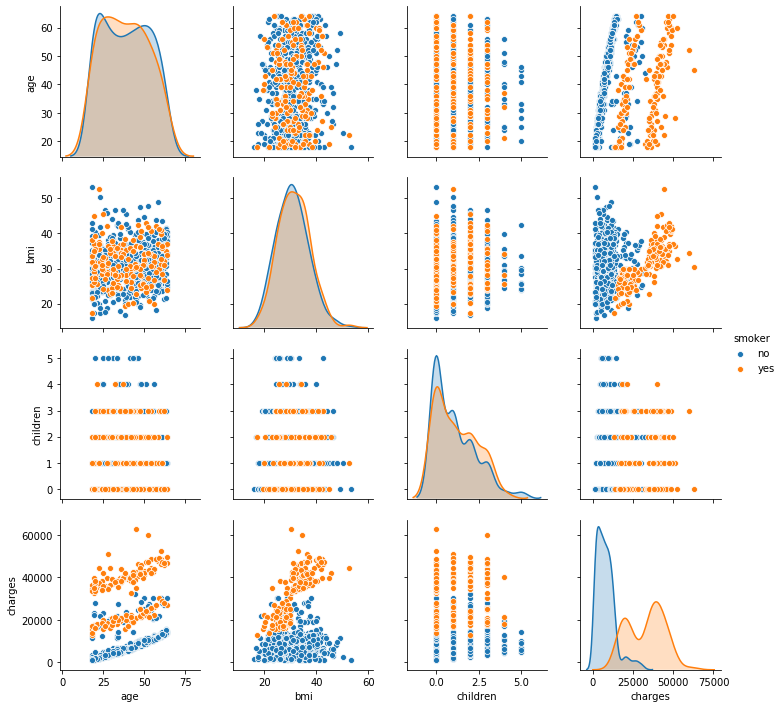

In [67]:
gen = df.groupby('sex')
df_male = gen.get_group('male')
sns.pairplot(df_male,hue="smoker")

##### 2) Pair Plot visualizing female population and separating smokers and non-smokers with hue

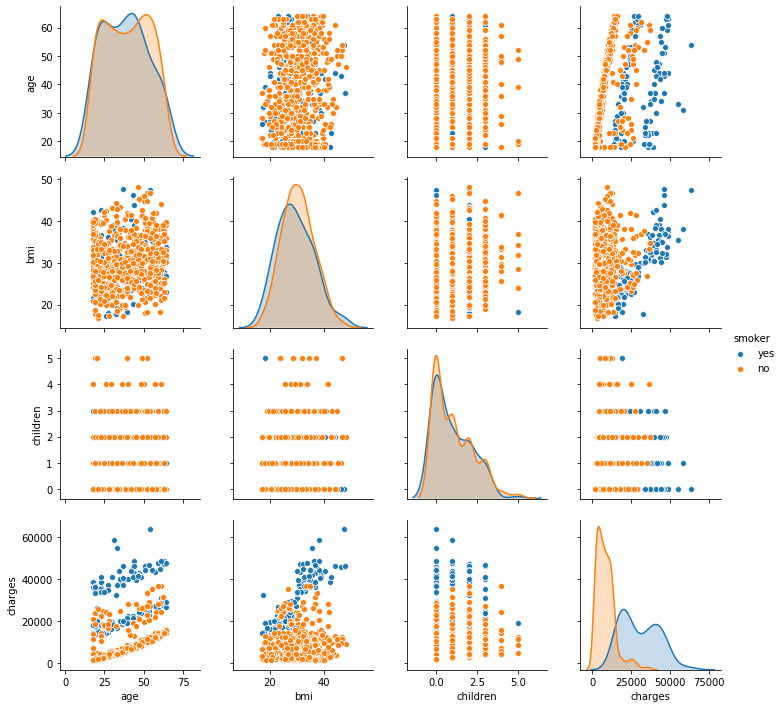

In [68]:
df_female = gen.get_group('female')
sns.pairplot(df_female,hue="smoker")

### 4a) Do charges of people who smoke differ significantly from the people who don't?

In [69]:
smk = df.groupby('smoker')
nsmk = smk.get_group('no')
nArray = np.array(nsmk['charges'])
ysmk = smk.get_group('yes')
yArray = np.array(ysmk['charges'])
t_statistic, p_value = ttest_ind(yArray, nArray)
print(t_statistic, p_value)
# p_value < 0.05 => alternative hypothesis:
# they don't have the same mean at the 5% significance level
print ("two-sample t-test p-value=", p_value)
print (f'As p_value of {p_value} < 0.05 the difference is significant => we reject the null hypothesis')

46.664921172723716 8.271435842177219e-283
two-sample t-test p-value= 8.271435842177219e-283
As p_value of 8.271435842177219e-283 < 0.05 the difference is significant => we reject the null hypothesis


### 4b) Does bmi of males differ significantly from that of females? 

In [70]:
gen = df.groupby('sex')
mBmi = gen.get_group('male')
mArray = np.array(mBmi['bmi'])
fBmi = gen.get_group('female')
fArray = np.array(fBmi['bmi'])
t_statistic, p_value = ttest_ind(mArray, fArray)
print(t_statistic, p_value)
print (f'As p_value of {round(p_value,4)} > 0.05 the difference is not significant => fail to reject the null hypothesis')

1.696752635752224 0.08997637178984932
As p_value of 0.09 > 0.05 the difference is not significant => fail to reject the null hypothesis


### 4c) Is the proportion of smokers significantly different in different genders? 

In [71]:
gen = df.groupby('sex')
m_count = df.sex.value_counts()[0]
f_count = df.sex.value_counts()[1]
m_Smk = gen.get_group('male').smoker.value_counts()[1]
f_Smk = gen.get_group('female').smoker.value_counts()[1]

print([f_Smk, m_Smk] , [f_count, m_count])

[115, 159] [662, 676]


In [72]:
stat, pval = proportions_ztest([f_Smk, m_Smk] , [f_count, m_count])

if pval < 0.05:
    print(f'With a p-value of {round(pval,4)} the difference is significant. aka |We reject the null|')
else:
    print(f'With a p-value of {round(pval,4)} the difference is not significant. aka |We fail to reject the null|')

With a p-value of 0.0053 the difference is significant. aka |We reject the null|


### 4d) Is the distribution of bmi across women with no children, one child and two children, the same?

In [73]:
gen = df.groupby(['sex','children'])
c1_zero = np.array(gen.get_group(('female',0)).bmi.iloc[:-170])
c1_one = np.array(gen.get_group(('female',1)).bmi.iloc[:-39])
c1_two = np.array(gen.get_group(('female',2)).bmi)
bmi_child_df = pd.DataFrame()

df_c0            = pd.DataFrame({'Child': '0', 'Mean_bmi':c1_zero})
df_c1            = pd.DataFrame({'Child': '1', 'Mean_bmi':c1_one})
df_c2            = pd.DataFrame({'Child': '2', 'Mean_bmi':c1_two})

bmi_child_df = bmi_child_df.append(df_c0) 
bmi_child_df = bmi_child_df.append(df_c1) 
bmi_child_df = bmi_child_df.append(df_c2)

mod = ols('Mean_bmi ~ Child', data = bmi_child_df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq     df         F    PR(>F)
Child        28.300876    2.0  0.385917  0.680113
Residual  12980.137676  354.0       NaN       NaN


p value is 0.680113 and it is more than our chosen level of signifance at 5%

So the statistical decision is that we fail to reject the null hypothesis at 5% level of significance.

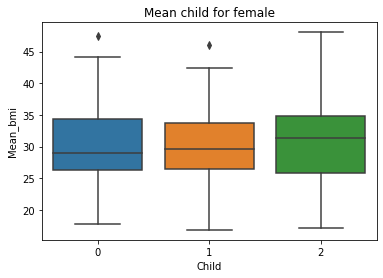

In [74]:
sns.boxplot(x = "Child", y = "Mean_bmi", data = bmi_child_df)
plt.title('Mean child for female')
plt.show()